# Qualtrics Data Analysis
---
This notebook analyzes all types of data from users in the Data & GIS Lab, from their major and the busiest time or week here in the lab. By combining lab statistics from LibAnalytics and Qualtrics from the past few years, the goal is to find out how to best utilize the lab for students.


---
### The raw code for this IPython notebook is by default hidden for easier reading. To toggle on/off the raw code, click the link below.

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [53]:
%matplotlib inline
import pandas as pd 
import os
import numpy as np
import re
import datetime as dt
import calendar as cal
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
pd.set_option('display.max_rows', 100)

Here, I imported the merged dataset and made a copy of it to work with so none of the original data is changed.

In [54]:
#merged = pd.read_csv(r'C:\Users\lib-jeq004\Downloads\merged.csv')
merged = pd.read_csv('merged.csv')
df = merged.copy()
df = df.drop(['Unnamed: 0'], axis=1)

In [55]:
df.head()

,Additional Information,Department or Major,Duration of Question,Entered by,Notes,Purpose of Visit,Start Date,Start Time,User Type
0,NaN,NaN,16-20,Data/GIS Lab,Yes,GIS,NaN,NaN,UCSD undergrad
1,NaN,NaN,NaN,Data/GIS Lab,NaN,GIS,07/03/2019,10:00 AM,UCSD staff
2,NaN,NaN,NaN,Data/GIS Lab,NaN,Study,07/03/2019,10:00 AM,UCSD undergrad
3,NaN,Data Science,NaN,Data/GIS Lab,NaN,Data,06/26/2019,10:00 AM,UCSD undergrad
4,NaN,Math,NaN,Data/GIS Lab,NaN,Data,06/25/2019,10:00 AM,UCSD undergrad


# Cleaning Data
---

## Year and Quarter Reformatting

Starting off from the merged data, many of the columns contain missing values, inconsistent formats, and hard-to-decipher categorization. The first portion of the notebook is dedicated to cleaning and reformatting the data.

I chose to fill each missing value in the "Start Date" column with previous values because each entry with a missing date must either be on the date of the entry or after it. However, I needed a custom function to change the objects that Pandas' to_datetime() function created to workable datetime64 objects.

In [56]:
#filling nulls with values closest to them
df['Start Date'].fillna(method='bfill', inplace=True)
df['Start Date'] = pd.to_datetime(df['Start Date'])

#helper function to change datetime64 object to python datetime object
def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return dt.datetime.utcfromtimestamp(timestamp)


Creating a calendar consisting of the start and end dates of each quarter from 2015-2020, so that each entry can be categorized into a specific year and quarter. I pulled this data from UCSD's academic calednar for each year. This helps us to view the distribution of entries by quarter and how they differ each year. This calendar will need updating as each quarter passes.

In [57]:
#calendar of the beginning and end dates of quarters from 2015-2020
calendar = {
        2015:[[dt.datetime(2015, 1, 5), dt.datetime(2015, 3, 24), 'Winter'],
          [dt.datetime(2015, 3, 30), dt.datetime(2015, 6, 16), 'Spring'],
          [dt.datetime(2015, 9 ,28), dt.datetime(2015, 12, 15), 'Fall']
        ],
        2016:[[dt.datetime(2016, 1, 4), dt.datetime(2016, 3, 23), 'Winter'],
          [dt.datetime(2016, 3, 28), dt.datetime(2016, 6, 14), 'Spring'],
          [dt.datetime(2016, 9 ,26), dt.datetime(2016, 12, 13), 'Fall']
        ],
        2017:[[dt.datetime(2017, 1, 5), dt.datetime(2017, 3, 28), 'Winter'],
          [dt.datetime(2017, 3, 25), dt.datetime(2017, 6, 20), 'Spring'],
          [dt.datetime(2017, 10 ,2), dt.datetime(2017, 12, 19), 'Fall']
        ],
        2018:[[dt.datetime(2018, 1, 8), dt.datetime(2018, 3, 27), 'Winter'],
          [dt.datetime(2018, 4, 2), dt.datetime(2018, 6, 19), 'Spring'],
          [dt.datetime(2018, 9 ,28), dt.datetime(2018, 12, 18), 'Fall']
        ],
        2019:[[dt.datetime(2019, 1, 4), dt.datetime(2019, 3, 26), 'Winter'],
          [dt.datetime(2019, 3, 28), dt.datetime(2019, 6, 18), 'Spring'],
          [dt.datetime(2019, 9 ,28), dt.datetime(2019, 12, 17), 'Fall']
        ],
        2020:[[dt.datetime(2020, 1, 4), dt.datetime(2020, 3, 24), 'Winter'],
          [dt.datetime(2020, 3, 28), dt.datetime(2020, 6, 16), 'Spring'],
          [dt.datetime(2020, 10 ,1), dt.datetime(2020, 12, 22), 'Fall']
        ]
}



Here, I create the year column by simply taking the first 4 characters of the already reformatted start date column.

As for the quarter column, I compared each entry's datetime object with datetime objects of the start and end dates of each quarter from the calendar above. This way, each entry would be classified into a quarter. To expand on that, I also categorized each entry into academic years. This was different from normal years, since academic years begin in the fall of one year and end in the spring of the next year. 

In [58]:
#Retrieving just the year 
df['Year'] = df.apply(lambda x: str(x['Start Date'])[0:4], axis=1)

In [59]:
#Determining the quarter of each entry
def quarter(row):
    
    if row['Start Date'] == 0:
        return np.nan
    
    date = to_datetime(row['Start Date'])
    
    quarter = "Break"
    for quarters in calendar.get(date.year):
        if date >= quarters[0] and date <= quarters[1]:
            quarter =  quarters[2]
            

    return quarter

df['Quarter'] = df.apply(quarter, axis = 1)
#filling nulls with values closest to them
df['Quarter'].fillna(method='ffill', inplace=True)

In [60]:
def academic_year(row):
    year = int(row['Year'])
    quarter = row['Quarter']
    if quarter == 'Break':
        return 'Break'
    if year == 2015:
        if quarter in ['Winter', 'Spring']:
            return '2014-2015 Academic Year'
        else:
            return '2015-2016 Academic Year'
    if year == 2016:
        if quarter in ['Winter', 'Spring']:
            return '2015-2016 Academic Year'
        else:
            return '2016-2017 Academic Year'
    if year == 2017:
        if quarter in ['Winter', 'Spring']:
            return '2016-2017 Academic Year'
        else:
            return '2017-2018 Academic Year'
    if year == 2018:
        if quarter in ['Winter', 'Spring']:
            return '2017-2018 Academic Year'
        else:
            return '2018-2019 Academic Year'
    if year == 2019:
        if quarter in ['Winter', 'Spring']:
            return '2018-2019 Academic Year'
        else:
            return '2019-2020 Academic Year'
df['Academic Year'] = df.apply(academic_year, axis=1)


In [61]:
df.head()

,Additional Information,Department or Major,Duration of Question,Entered by,Notes,Purpose of Visit,Start Date,Start Time,User Type,Year,Quarter,Academic Year
0,NaN,NaN,16-20,Data/GIS Lab,Yes,GIS,2019-07-03,NaN,UCSD undergrad,2019,Break,Break
1,NaN,NaN,NaN,Data/GIS Lab,NaN,GIS,2019-07-03,10:00 AM,UCSD staff,2019,Break,Break
2,NaN,NaN,NaN,Data/GIS Lab,NaN,Study,2019-07-03,10:00 AM,UCSD undergrad,2019,Break,Break
3,NaN,Data Science,NaN,Data/GIS Lab,NaN,Data,2019-06-26,10:00 AM,UCSD undergrad,2019,Break,Break
4,NaN,Math,NaN,Data/GIS Lab,NaN,Data,2019-06-25,10:00 AM,UCSD undergrad,2019,Break,Break


## Determining Week of Entry

This helper function was super helpful in listing out intervals between datetime objects. I specified the interval to be 7, as I was trying to create weekly intervals to classify each entry into. I wanted to make weekly intervals so that I can analyze what week of the quarter was the busiest, but this meant listing out the weeks of each unique quarter from 2015-2020, so a loop through each quarter's start and end date made this process much easier.

In [62]:
#helper function that lists out ranges between two dates in intervals of weeks
def daterange(startdate, enddate, steps=7): 
    """Yields dates in increments of steps days from startdate to enddate"""
    numdays = (enddate-startdate).days 
    for x in range (0, numdays, steps):
        yield startdate + dt.timedelta(days = x)

By finding the week range that entry belongs to, I classified each entry to a week number between 0-11. Week 0 stood for anytime the entry was during a school break, and week 11 stood for finals week. I also classified the day of the week using the calendar package that maps each date to the English name for day of the week.

In [63]:
#Determining the week of each entry 
#0 - Break
#11 - Finals Week

def week_of_quarter(row):
    
    #Break, denoted by 0
    if row['Quarter'] == 'Break':
        return 0
    
    date = to_datetime(row['Start Date'])
    year = date.year
    if row['Quarter'] == 'Winter':
        index = 0
    elif row['Quarter'] == 'Spring':
        index = 1
    elif row['Quarter'] == 'Fall':
        index = 2
    
    weeks = list(daterange(calendar.get(year)[index][0], calendar.get(year)[index][1]))
    if date >= weeks[0] and date < weeks[1]:
        return 1
    if date >= weeks[1] and date < weeks[2]:
        return 2
    if date >= weeks[2] and date < weeks[3]:
        return 3
    if date >= weeks[3] and date < weeks[4]:
        return 4
    if date >= weeks[4] and date < weeks[5]:
        return 5
    if date >= weeks[5] and date < weeks[6]:
        return 6
    if date >= weeks[6] and date < weeks[7]:
        return 7
    if date >= weeks[7] and date < weeks[8]:
        return 8
    if date >= weeks[8] and date < weeks[9]:
        return 9
    if date >= weeks[9] and date < weeks[10]:
        return 10
    #Finals week, denoted by 11
    if date >= weeks[10] and date < weeks[11]:
        return 11
    

df['Week'] = df.apply(week_of_quarter, axis=1)
df['Week'].fillna(method='bfill', inplace=True)

In [64]:
def day_of_week(row):
    date = row['Start Date']
    return cal.day_name[date.weekday()]
df['Day of Week'] = df.apply(day_of_week, axis = 1)

In [65]:
df.head()

,Additional Information,Department or Major,Duration of Question,Entered by,Notes,Purpose of Visit,Start Date,Start Time,User Type,Year,Quarter,Academic Year,Week,Day of Week
0,NaN,NaN,16-20,Data/GIS Lab,Yes,GIS,2019-07-03,NaN,UCSD undergrad,2019,Break,Break,0.0,Wednesday
1,NaN,NaN,NaN,Data/GIS Lab,NaN,GIS,2019-07-03,10:00 AM,UCSD staff,2019,Break,Break,0.0,Wednesday
2,NaN,NaN,NaN,Data/GIS Lab,NaN,Study,2019-07-03,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Wednesday
3,NaN,Data Science,NaN,Data/GIS Lab,NaN,Data,2019-06-26,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Wednesday
4,NaN,Math,NaN,Data/GIS Lab,NaN,Data,2019-06-25,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Tuesday


## Major, Duration of Question, and Purpose of Visit

Reformatting string patterns for the Major, Duration of Question, and Purpose of Visit columns since they all had repetitive information.

In the major column, each string had different capitalization formats, so I made them all into title formats (first letter capitalized) to organize the formatting. Then, I consolidated many of the titles that referred to one major, such as 'Cs' or 'Computer Science', which all meant "CSE".

Similarly, for the duration of question column, I organized the formatting so that each value contained "minutes" at the end for easier understanding, as well as reorganized the range of durations.

Finally, the purpose of visit column had the highest number of repetitive values. I consolidated many different formats for one value into a list of common values, such as "study", "data", "GIS", "entry", etc.

In [66]:
df['Department or Major'] = df['Department or Major'].str.title()
df['Department or Major'] = df['Department or Major'].replace(['Cs', 'Computer Science'], 'Cse')
df['Department or Major'] = df['Department or Major'].replace(['Bio Engineering', 'Bio Eng', 'Bioeng'], 'Beng')

In [67]:

df['Duration of Question'] = df['Duration of Question'].replace("6-10", "6-10 Minutes")
df['Duration of Question'] = df['Duration of Question'].replace("1-5", "1-5 Minutes")
df['Duration of Question'] = df['Duration of Question'].replace("11-15", "11-15 Minutes")
df['Duration of Question'] = df['Duration of Question'].replace("16-20", "16-20 Minutes")
df['Duration of Question'] = df['Duration of Question'].replace("31 +", "30 Minutes or Longer")
df['Duration of Question'] = df['Duration of Question'].replace("21-30", "21-30 Minutes")


In [68]:
df['Purpose of Visit'] = df['Purpose of Visit'].replace(
    ['Entry;Purpose of Visit: Study', 'Purpose of Visit: Study'], 'Study')
df['Purpose of Visit'] = df['Purpose of Visit'].replace(
    ['Entry;Purpose of Visit: GIS', 'Purpose of Visit: GIS', 'Type of Question: GIS', 'Entry;Type of Question: GIS', 'Entry;Purpose of Visit: GIS;Purpose of Visit: Study', 'Entry;Purpose of Visit: GIS;Type of Question: GIS'], 
    'GIS')
df['Purpose of Visit'] = df['Purpose of Visit'].replace(
    ['Purpose of Visit: Data', 'Entry;Purpose of Visit: Data', 'Entry;Type of Question: Data', 'Type of Question: Data', 'Entry;Purpose of Visit: Data;Type of Question: Data'], 'Data')
df['Purpose of Visit'] = df['Purpose of Visit'].replace(
    ['Type of Question: Directional', 'Entry;Type of Question: Directional'], 'Directional')
df['Purpose of Visit'] = df['Purpose of Visit'].replace(
    ['Entry;Purpose of Visit: Other', 'Purpose of Visit: Other','Unknown'], 'Other')

In [69]:
df.head()

,Additional Information,Department or Major,Duration of Question,Entered by,Notes,Purpose of Visit,Start Date,Start Time,User Type,Year,Quarter,Academic Year,Week,Day of Week
0,NaN,NaN,16-20 Minutes,Data/GIS Lab,Yes,GIS,2019-07-03,NaN,UCSD undergrad,2019,Break,Break,0.0,Wednesday
1,NaN,NaN,NaN,Data/GIS Lab,NaN,GIS,2019-07-03,10:00 AM,UCSD staff,2019,Break,Break,0.0,Wednesday
2,NaN,NaN,NaN,Data/GIS Lab,NaN,Study,2019-07-03,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Wednesday
3,NaN,Data Science,NaN,Data/GIS Lab,NaN,Data,2019-06-26,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Wednesday
4,NaN,Math,NaN,Data/GIS Lab,NaN,Data,2019-06-25,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Tuesday


## Time 

The time column was filled with all sorts of formats that needs to be consolidate into one format. I chose to organize them all into the standard format of hour:minute with AM or PM attached to the end.

Before cleaning the time column by assigning AM and PM to each time, I filled the empty values with the time closest to that entry. Figuring out which time was in the morning and in the evenings was the hardest part, so if a time wasn't assigned a AM or PM already, I would retrieve the digits corresponding the hour using regex. After retrieving either 1 or 2 digits, I classified hours 7-11 as morning times, and anything after 12 as evening times. By appending the "AM" or "PM" strings to the end of each entry, it was much easier to classify times and find out when the busiest time of day was for the lab.

In [70]:
df['Start Time'].fillna(method='bfill', inplace=True)
#Assigning AM and PM to times
def time(row):
    time = row['Start Time']
    hour = int(re.search('[0-9]{1,2}', time).group(0))
    if time[-2:] != "AM" and time[-2:] != "PM":
        if hour >= 7 and hour <=11:
            time += ' AM'
            return time
        if hour > 12:
            hour = hour - 12
            rest = time[2:]
            time = str(hour) + rest
            time += ' PM'
            return time
        else:
            time += ' PM'
            return time
    else:
        return time
        
df['Time'] = df.apply(time, axis=1)



The hour column was derived from the time column so that I could group times into hour intervals, making it easier to label axes on the graphs for analysis.

In [71]:
#Assigning hour of the day, for easier categorization
def hour(row):
    time = row['Time']
    hour = (re.search('[0-9]{1,2}', time).group(0))
    am_pm = time[-2:]
    return hour + am_pm
df['Hour'] = df.apply(hour, axis=1)

In [72]:
df.head()

,Additional Information,Department or Major,Duration of Question,Entered by,Notes,Purpose of Visit,Start Date,Start Time,User Type,Year,Quarter,Academic Year,Week,Day of Week,Time,Hour
0,NaN,NaN,16-20 Minutes,Data/GIS Lab,Yes,GIS,2019-07-03,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Wednesday,10:00 AM,10AM
1,NaN,NaN,NaN,Data/GIS Lab,NaN,GIS,2019-07-03,10:00 AM,UCSD staff,2019,Break,Break,0.0,Wednesday,10:00 AM,10AM
2,NaN,NaN,NaN,Data/GIS Lab,NaN,Study,2019-07-03,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Wednesday,10:00 AM,10AM
3,NaN,Data Science,NaN,Data/GIS Lab,NaN,Data,2019-06-26,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Wednesday,10:00 AM,10AM
4,NaN,Math,NaN,Data/GIS Lab,NaN,Data,2019-06-25,10:00 AM,UCSD undergrad,2019,Break,Break,0.0,Tuesday,10:00 AM,10AM


# Reports
---

Keeping track of the count of each value for the different columns in consideration. I also created a count column, which is just a colum of all 1's that can be used for pivot tables.

In this section, I create pivot tables and graphs that show how the lab is used. Some are univariate analysis, and others combine multiple variables to look at the differences between each entry. 

In [73]:
quarter_data = df['Quarter'].value_counts()
week_data = df['Week'].value_counts()
hour_data = df['Hour'].value_counts()
year_data = df['Year'].value_counts()
df['Count'] = pd.Series([1] * df.shape[0])

## Quarter, Week, Hour, Bivariate Analysis

In this section, I wanted to take a look at the number of entries in a quarter, week, or hour out of all entries in the entire dataset. I used quarters, weeks, and hours as the X axis labels, and the Y axis contained the number of entries for that category.

In my findings, I observed that Fall and Winter had the most users in the lab. Also, during weeks 4, 5, and 10 had the most users in the lab as well, most likely from people studying for midterms and finals. One interesting thing is that the lab sees a lot of usage during Week 1 and 2, which could just be people wanting to explore the space or finding new study spaces.

The hour by hour analysis was also interesting; most people used the lab about 2 hours before and after noon. There aren't many people in the lab in the morning or in the late evenings, which means that the lab is usually staffed at the times when there are the most people in the lab.

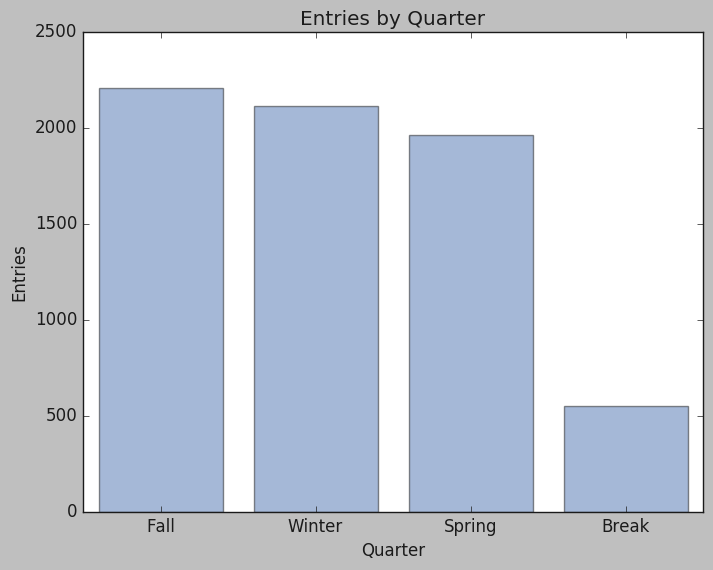

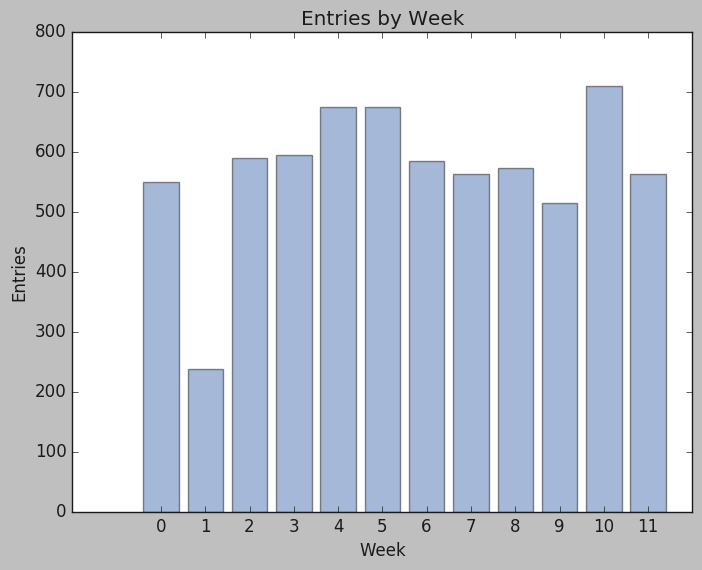

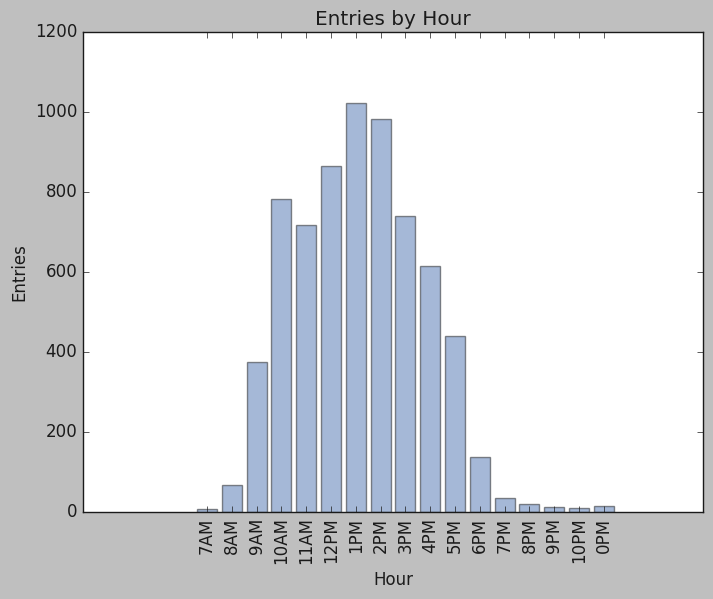

In [74]:
from matplotlib.backends.backend_pdf import PdfPages

#All time reports
def quarter_reports():
    f = plt.figure()
    objects = quarter_data.index
    y_pos = np.arange(len(objects))
    performance = quarter_data.values
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.xlabel('Quarter')
    plt.ylabel('Entries')
    plt.title('Entries by Quarter')
    
    plt.show()
    

def week_reports():
    
    week_data.sort_index(inplace=True)
    
    f = plt.figure()
    objects = week_data.index
    
    y_pos = np.arange(len(objects))
    performance = week_data.values
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, np.arange(12))
    plt.ylabel('Entries')
    plt.xlabel('Week')
    plt.title('Entries by Week')

    plt.show()


def hour_reports():
    
    order = ['7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM','6PM', '7PM', '8PM', '9PM', '10PM', '0PM']
    data = hour_data.reindex(order)
    
    f = plt.figure()
    objects = data.index
    y_pos = np.arange(len(objects))
    performance = data.values
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation = 'vertical')
    plt.ylabel('Entries')
    plt.xlabel('Hour')
    plt.title('Entries by Hour')

    plt.show()
    
    
quarter_reports()
week_reports()
hour_reports()

Here, I start doing analysis that involves two variables. First, I wanted to look at the trend of weekly usage across the different quarters. It seems that in every quarter, the amount of entries has remained fairly constant. I also looked at the week of day when users came into the lab, and found that most users visited during the weekdays, while the weekends did not see many years.

Another thing I observed from the quarter by academic year analysis is that there was a huge jump in users in the 2017-2018 academic year. That number has gone down since then for this year.

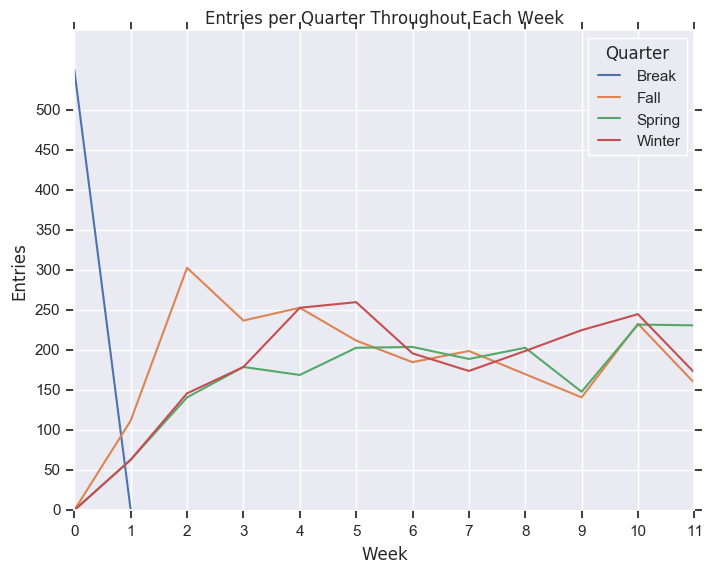

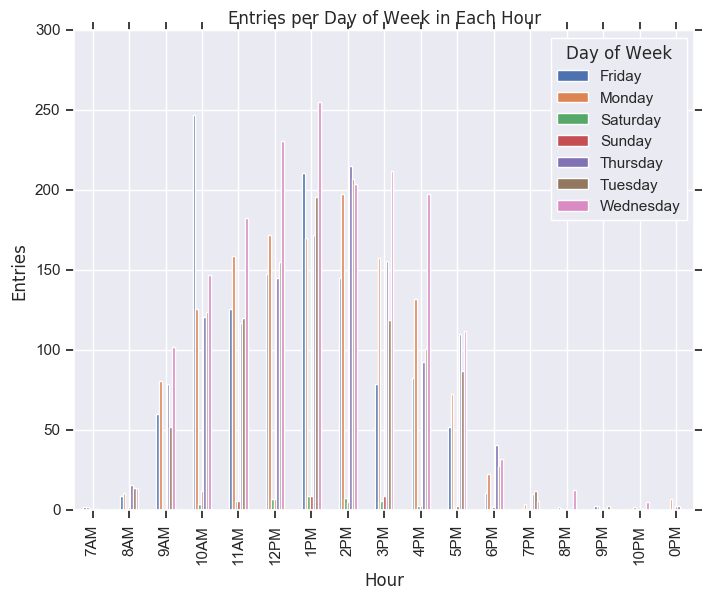

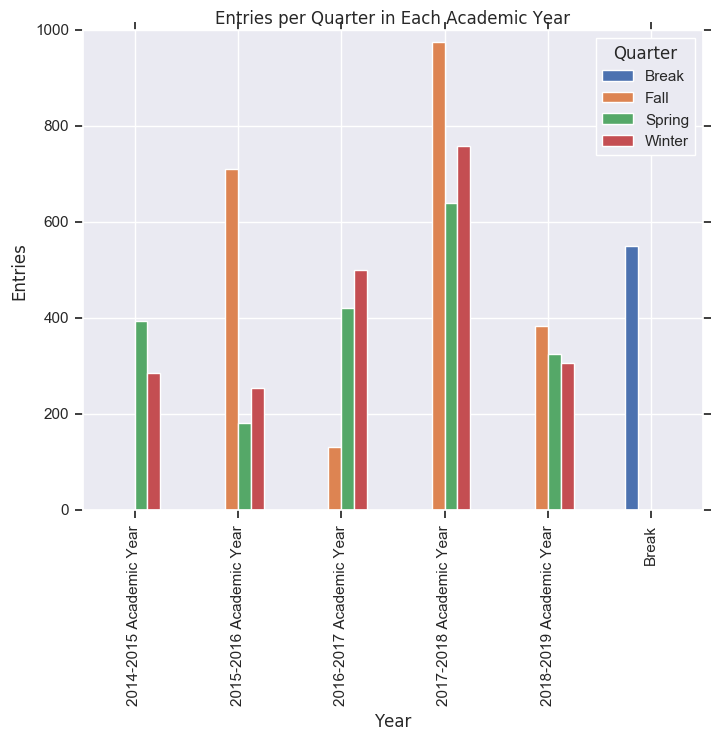

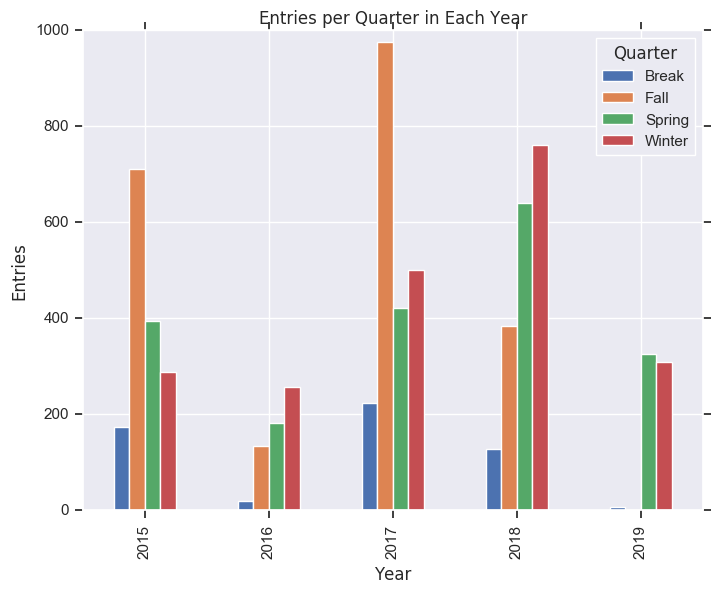

In [75]:

def quarter_by_week():
    f = plt.figure()
    q_w = pd.pivot_table(df,index= 'Week', columns='Quarter',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    
    sns.set()
    q_w.plot()
    plt.xlabel('Week')
    plt.ylabel('Entries')
    plt.title('Entries per Quarter Throughout Each Week')
    plt.xticks(np.arange(0,12,1))
    plt.yticks(np.arange(0,501,50))
    plt.show()
    
def dayofweek_by_hour():
    f = plt.figure()
    dow_h = pd.pivot_table(df,index= 'Hour', columns='Day of Week',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    order = ['7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM','6PM', '7PM', '8PM', '9PM', '10PM', '0PM']
    reindexed = dow_h.reindex(order)
    sns.set()
    reindexed.plot(kind='bar')
    plt.xlabel('Hour')
    plt.ylabel('Entries')
    plt.title('Entries per Day of Week in Each Hour')
    plt.show()
    
def acad_year_by_quarter():
    f = plt.figure()
    ay_q = pd.pivot_table(df,index= 'Academic Year', columns='Quarter',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    sns.set()
    ay_q.plot(kind='bar')
    plt.xlabel('Year')
    plt.ylabel('Entries')
    plt.title('Entries per Quarter in Each Academic Year')
    plt.show()
    
def year_by_quarter():
    f = plt.figure()
    y_q = pd.pivot_table(df,index= 'Year', columns='Quarter',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    sns.set()
    y_q.plot(kind='bar')
    plt.xlabel('Year')
    plt.ylabel('Entries')
    plt.title('Entries per Quarter in Each Year')
    plt.show()

quarter_by_week()
dayofweek_by_hour()
acad_year_by_quarter()
year_by_quarter()


## Major 

After cleaning the major data, I grouped the counts for each major and plotted them. CSE, GPS, and USP majors come into the lab the most. This makes sense because they are most likely utilizing the data analysis and data resources available on the lab computers. 

By dividing up the major usage in quarters, I saw that Fall had the most CSE majors come in to the lab. This may be due to the Fall courses having more projects that need more powerful computing resources. This is the same for more USP and CSE majors entering the lab in the Winter as well.

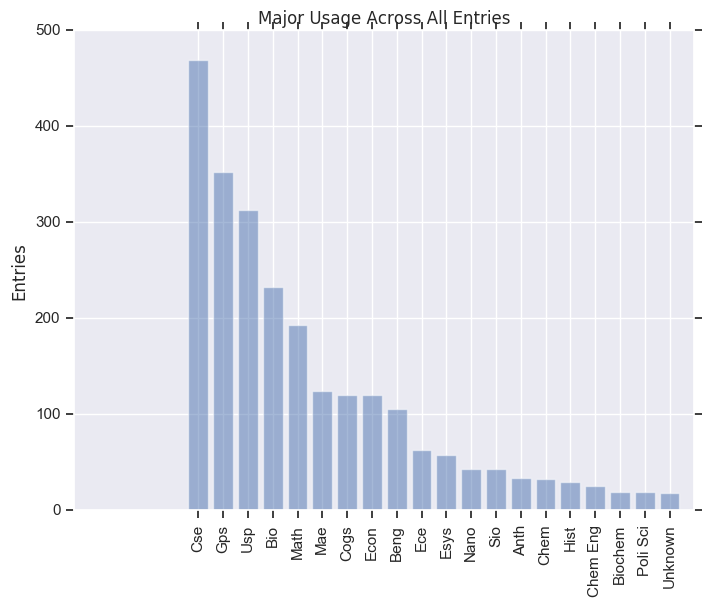

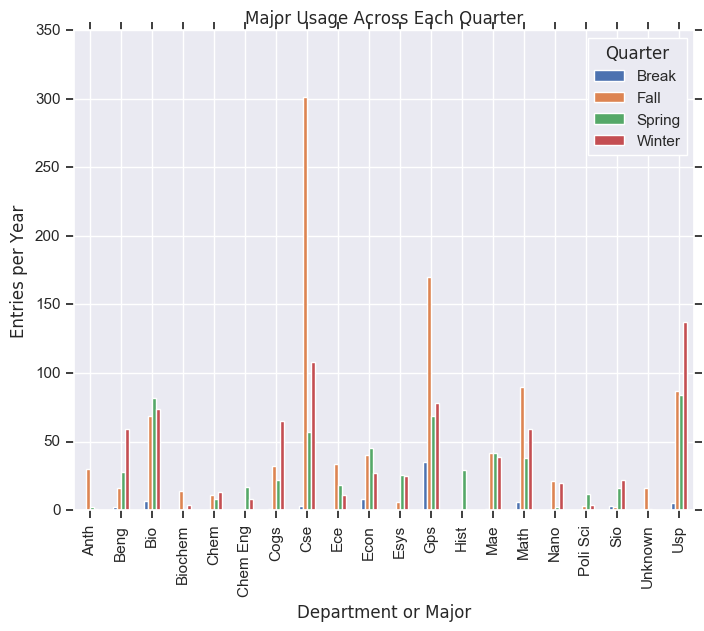

In [76]:
#majors
major_data = df['Department or Major'].value_counts()[:20]
def major_reports():
    
    objects = major_data.index
    y_pos = np.arange(len(objects))
    performance = major_data.values
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects,rotation='vertical')
    plt.ylabel('Entries')
    plt.title('Major Usage Across All Entries')
    
    
    top_majors = df[df['Department or Major'].isin(list(major_data.index))]
    m_q = pd.pivot_table(top_majors,index= 'Department or Major', columns='Quarter',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    m_q.plot(kind='bar')
    plt.ylabel('Entries per Year')
    plt.title('Major Usage Across Each Quarter')
    plt.show()
    
major_reports()

## Visitor Type and Duration of Question

Analyzed what people were coming into the lab for across all entries. 

It seemed like most people came into the lab for studying, assuming that the entry category are just people coming in to study as well. But nonetheless a good amount of people are also using the lab for its GIS and Data resources.

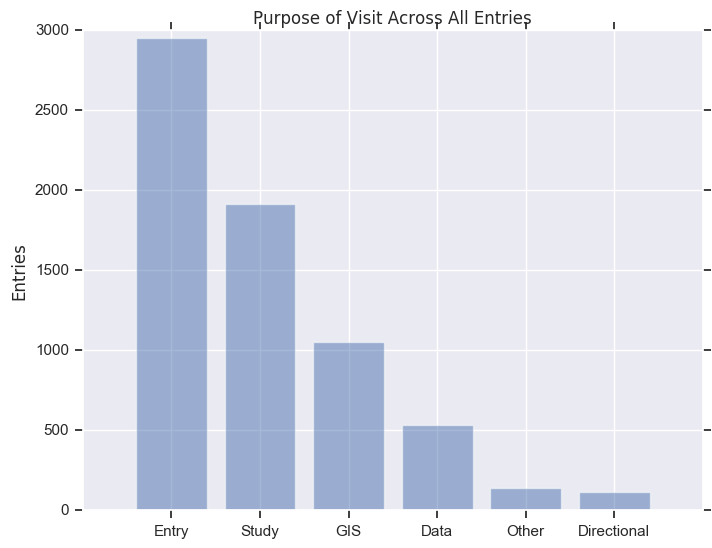

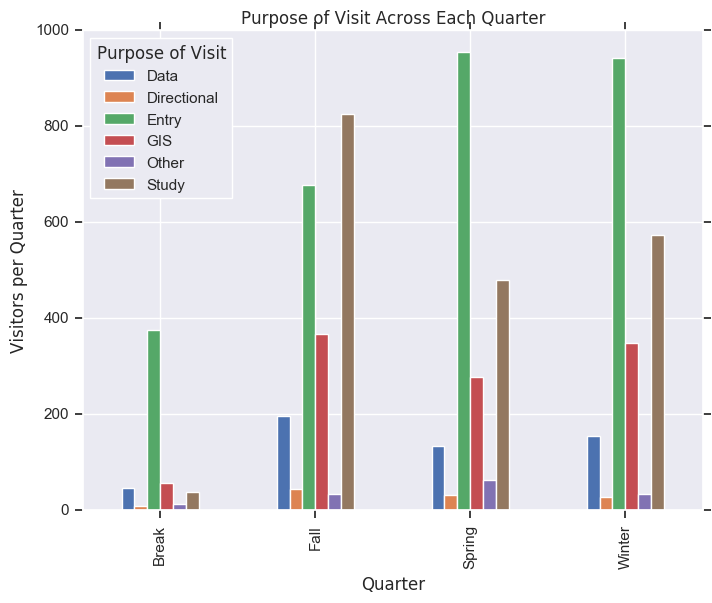

In [77]:
visit_data = df['Purpose of Visit'].value_counts()[:6]

def visitor_reports():
    objects = visit_data.index
    y_pos = np.arange(len(objects))
    performance = visit_data.values
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Entries')
    plt.title('Purpose of Visit Across All Entries')
    
    
    top_visitors = df[df['Purpose of Visit'].isin(list(visit_data.index))]
    visitor = pd.pivot_table(top_visitors,index= 'Quarter', columns='Purpose of Visit',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    visitor.plot(kind='bar')
    plt.title('Purpose of Visit Across Each Quarter')
    plt.ylabel('Visitors per Quarter')
    plt.show()
    
visitor_reports()

Looked at what type of users came into the lab and how long their visit was. Most of the people that visited were undergrad students, but I was surprised at the number of grad students or each staff that visited the lab. It shows that this lab isn't just used by students and attracts different types of visitors.

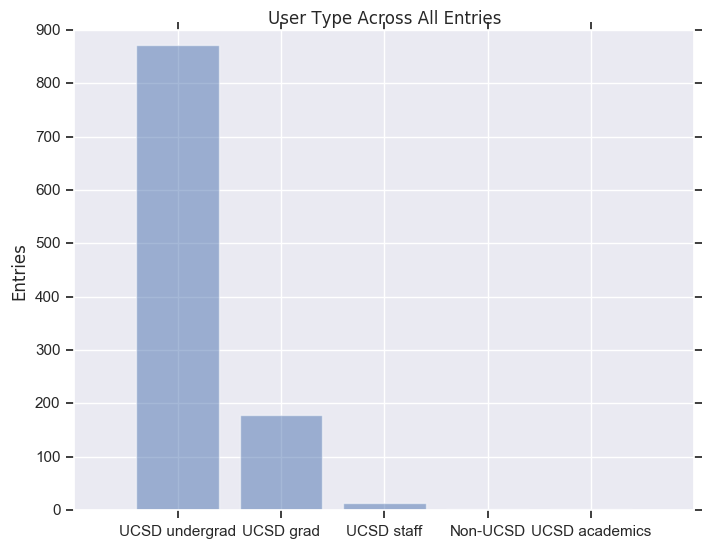

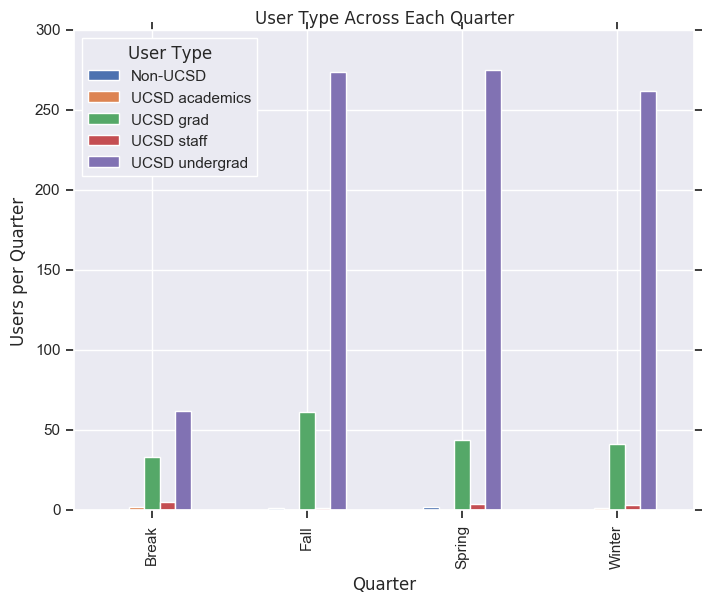

In [78]:
usertype_data = df['User Type'].value_counts()
duration_data = df['Duration of Question'].value_counts()

def usertype_report():
    objects = usertype_data.index
    y_pos = np.arange(len(objects))
    performance = usertype_data.values
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Entries')
    plt.title('User Type Across All Entries')
   
    
    user = pd.pivot_table(df,index= 'Quarter', columns='User Type',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    user.plot(kind='bar')
    plt.title('User Type Across Each Quarter')
    plt.ylabel('Users per Quarter')
    plt.show()
usertype_report()

From the duration reports, I see that most people that have questions come in for a short visit. I don't know how accurate these data are, since I see that many people who come into the lab that don't have questions stay for a much longer time. And when those people do ask questions and get it resolved, they usually end up staying longer in the lab.

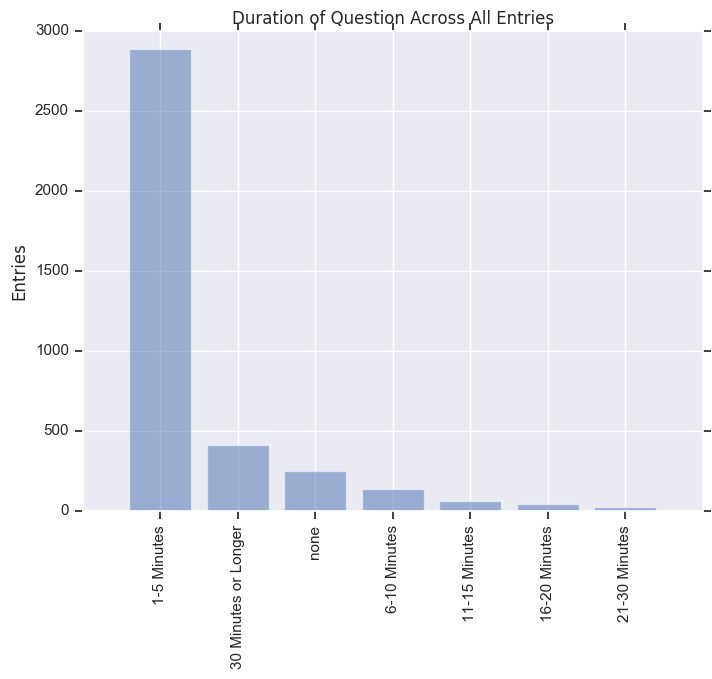

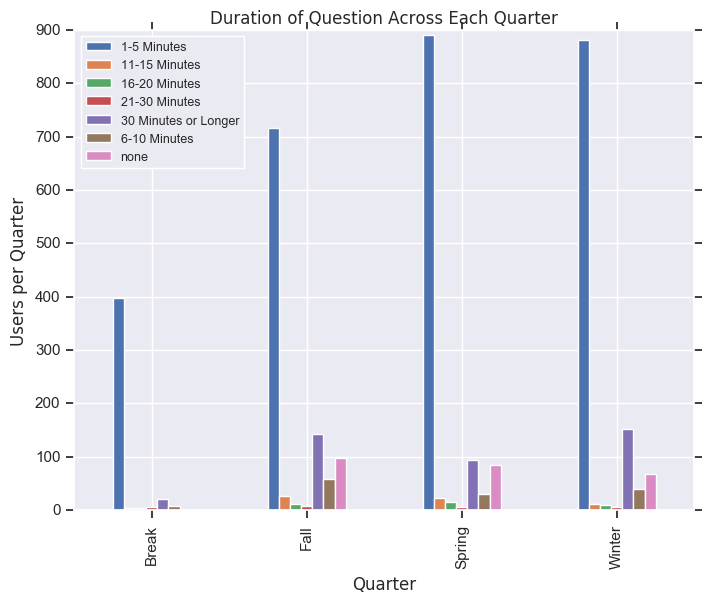

In [79]:
def duration_report():
    objects = duration_data.index
    y_pos = np.arange(len(objects))
    performance = duration_data.values
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation = 'vertical')
    plt.ylabel('Entries')
    plt.title('Duration of Question Across All Entries')
    
    
    duration = pd.pivot_table(df,index= 'Quarter', columns='Duration of Question',values = 'Count',
                      aggfunc=np.sum).fillna(0)
    duration.plot(kind='bar')
    plt.title('Duration of Question Across Each Quarter')
    plt.ylabel('Users per Quarter')
    plt.legend(loc=2, prop={'size': 9})
    plt.show()

duration_report()

# Final Summary

---
A collection of all the graphs created in this report. Looking back at the data, I was able to work around many of the inconsistencies within the data and was able to utilize most of the entries for analysis. There were many interesting discoveries that I found, such as what time people used the lab, what weeks were the busiest, and the majors of the people who came into the lab. 

These graphs can be used to make conclusions, or the pivot tables and series behind these graphs can be looked at (which are inside the functions for each graph).

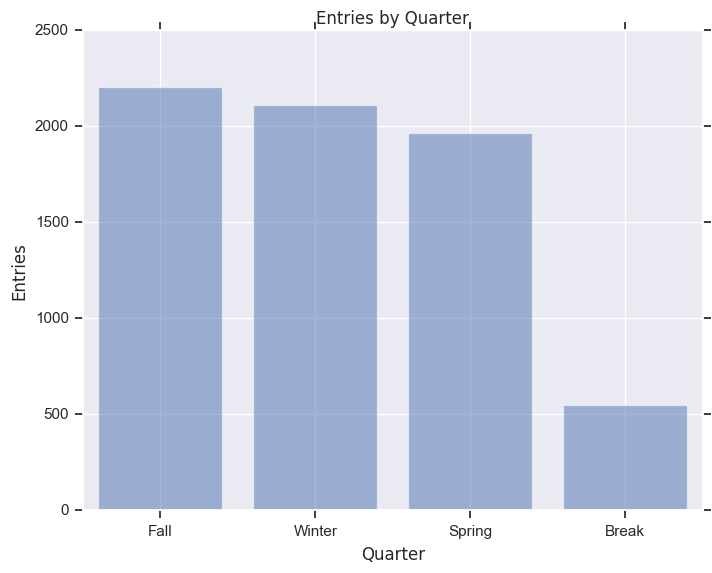

In [80]:
quarter_reports()


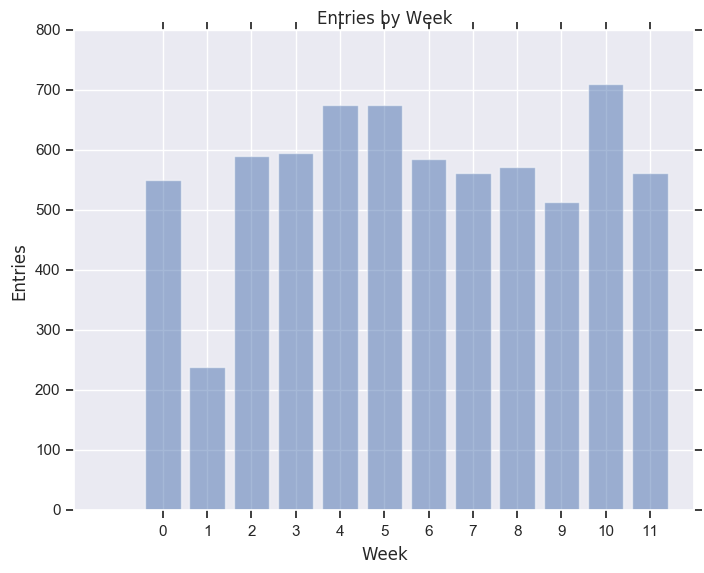

In [81]:
week_reports()

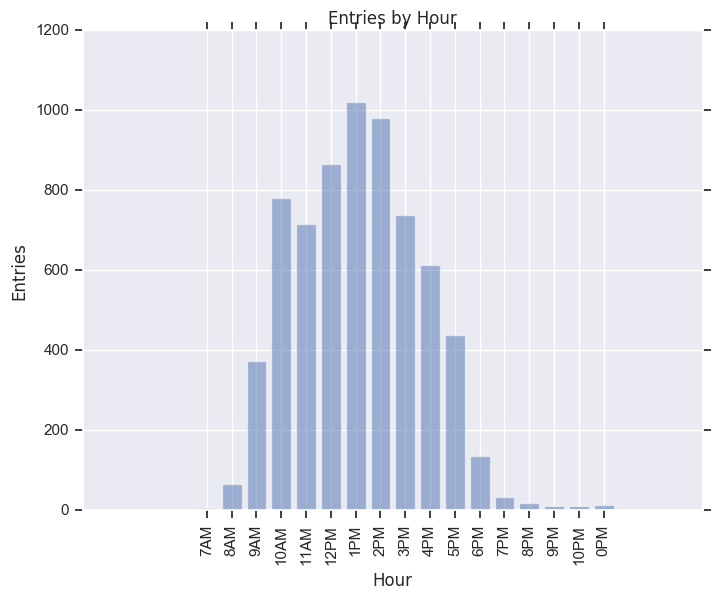

In [82]:
hour_reports()

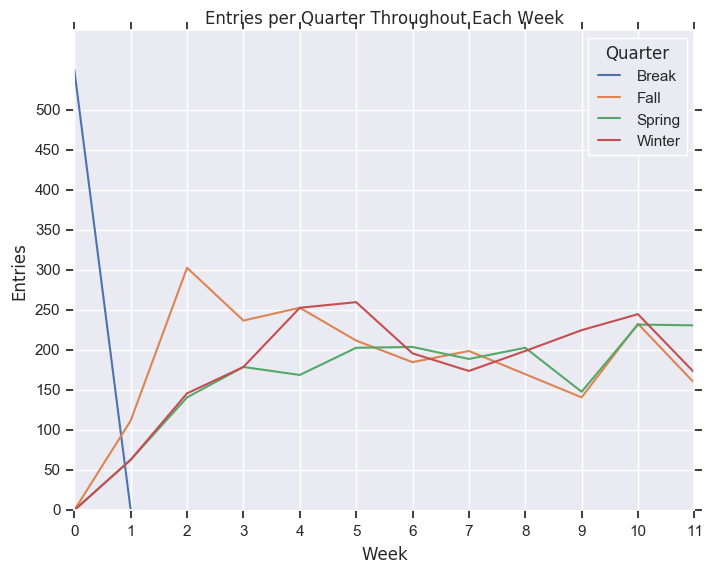

In [83]:
quarter_by_week()

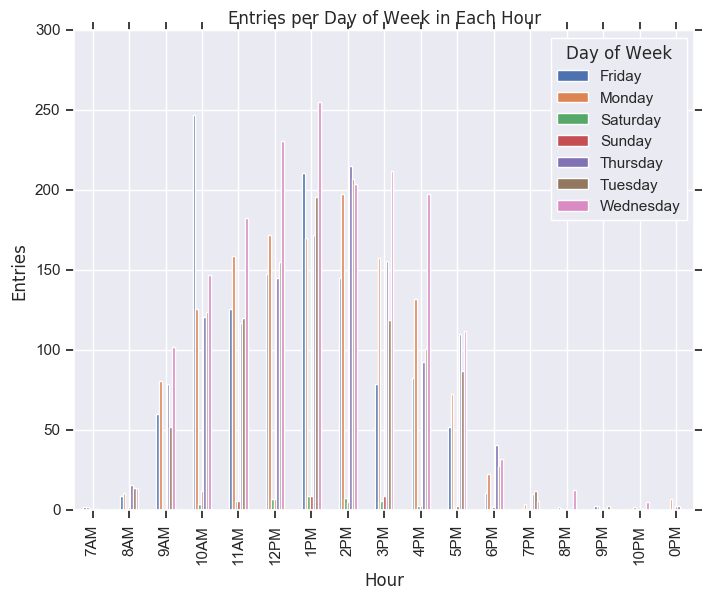

In [84]:
dayofweek_by_hour()

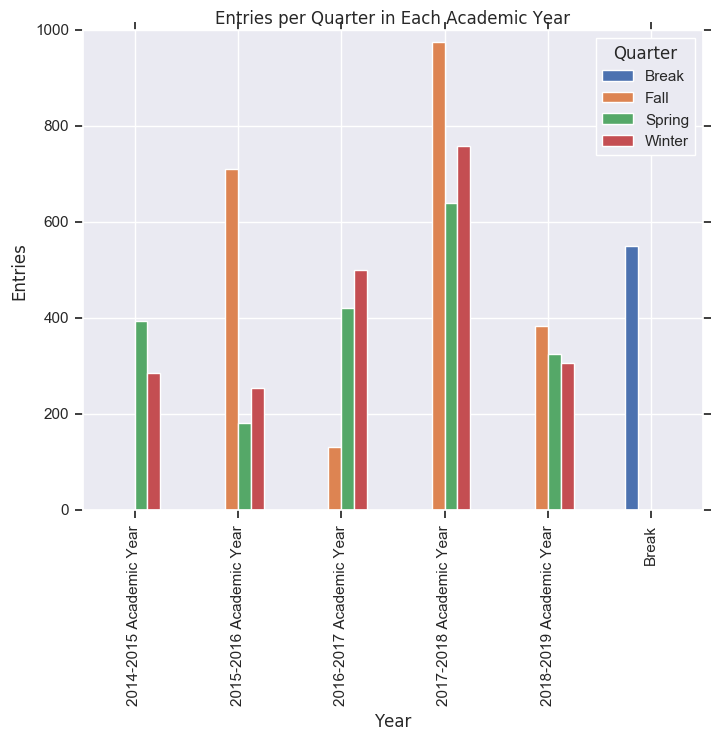

In [85]:
acad_year_by_quarter()

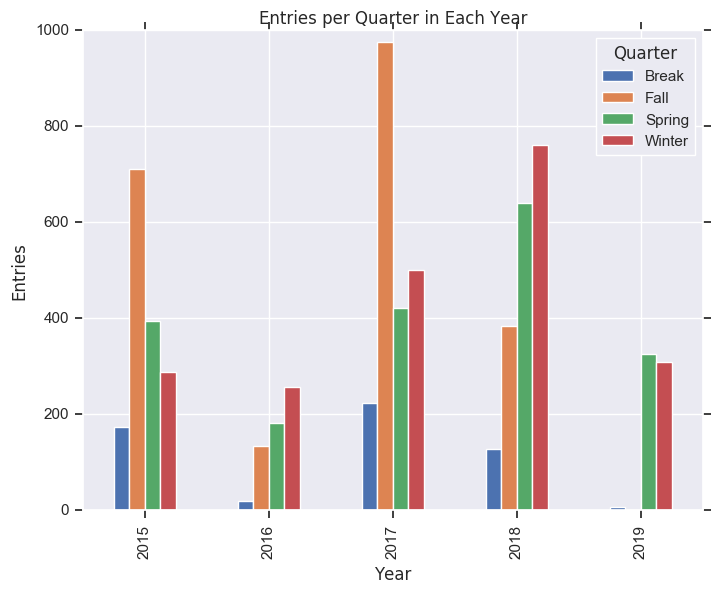

In [86]:
year_by_quarter()

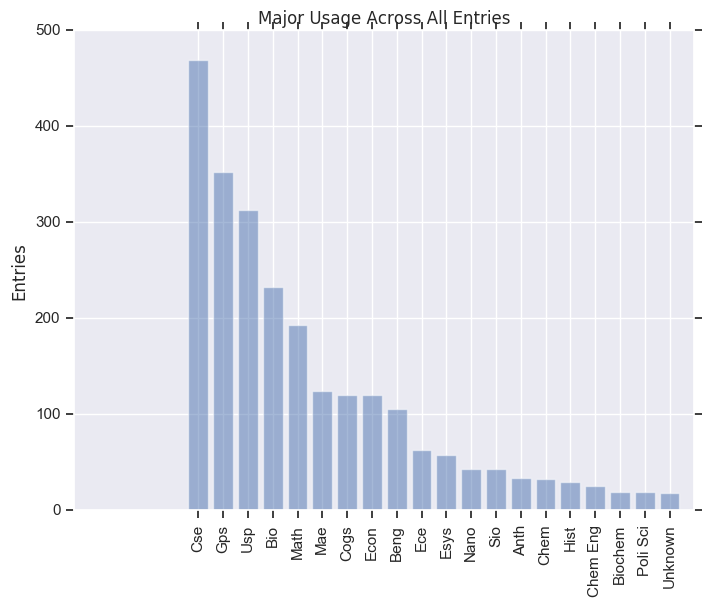

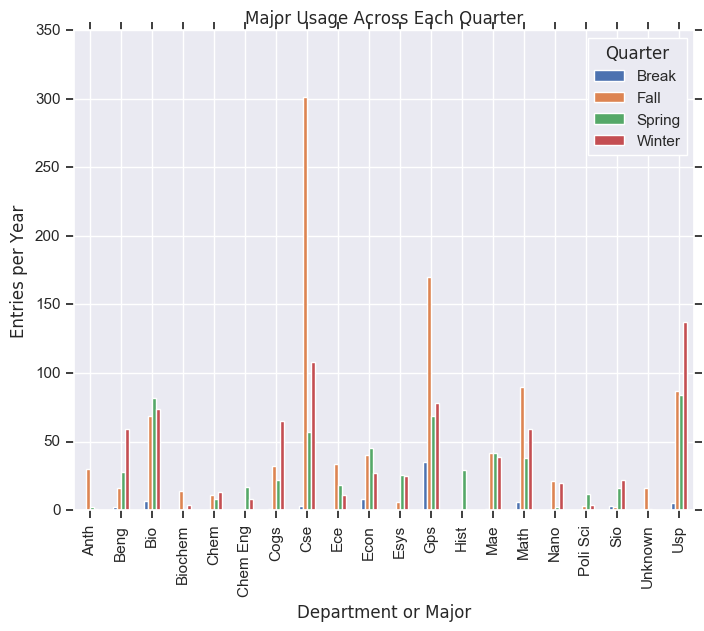

In [87]:
major_reports()

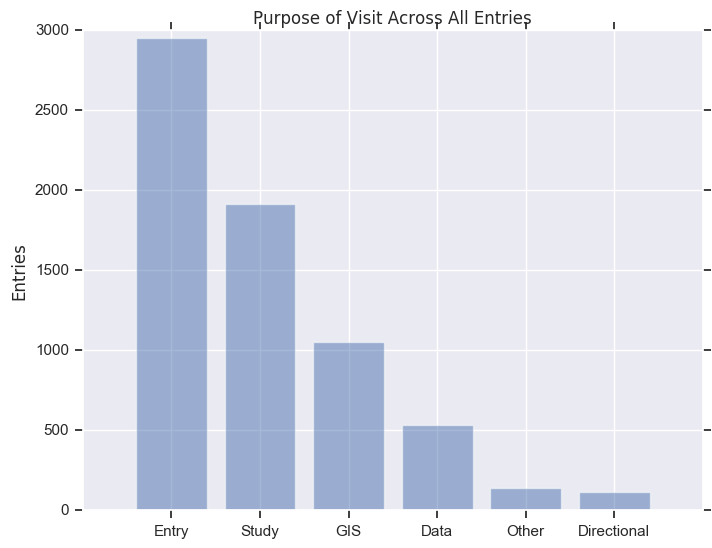

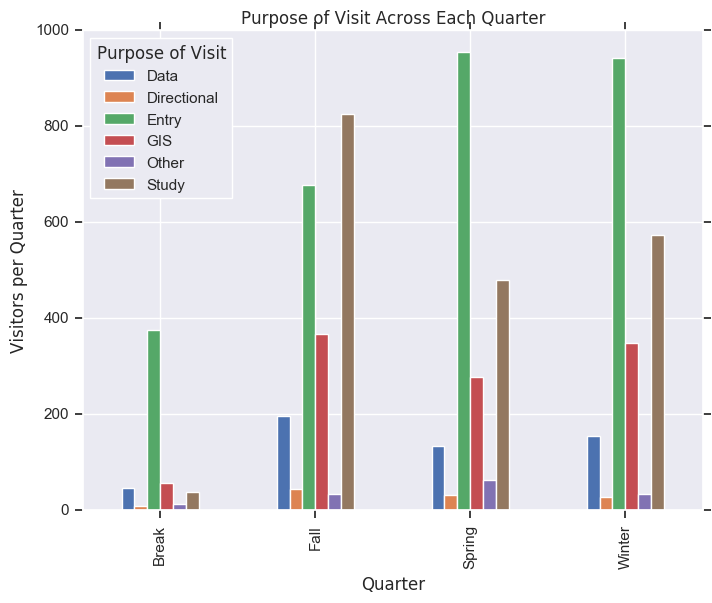

In [88]:
visitor_reports()

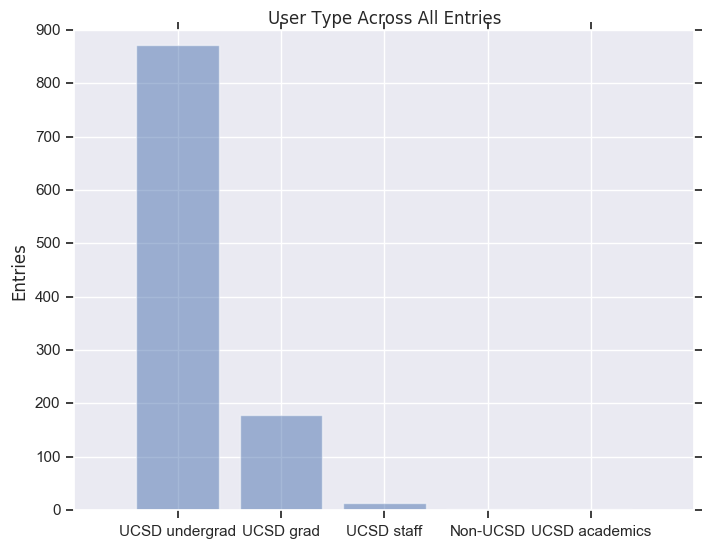

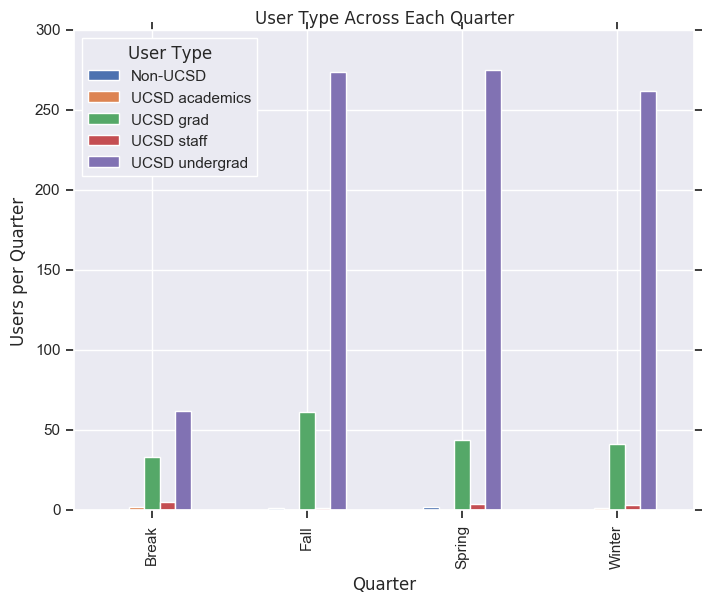

In [89]:
usertype_report()

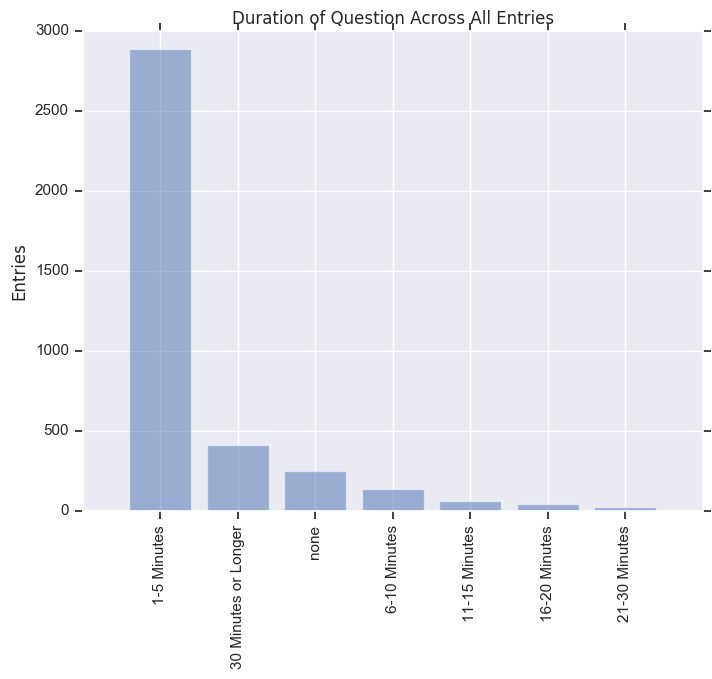

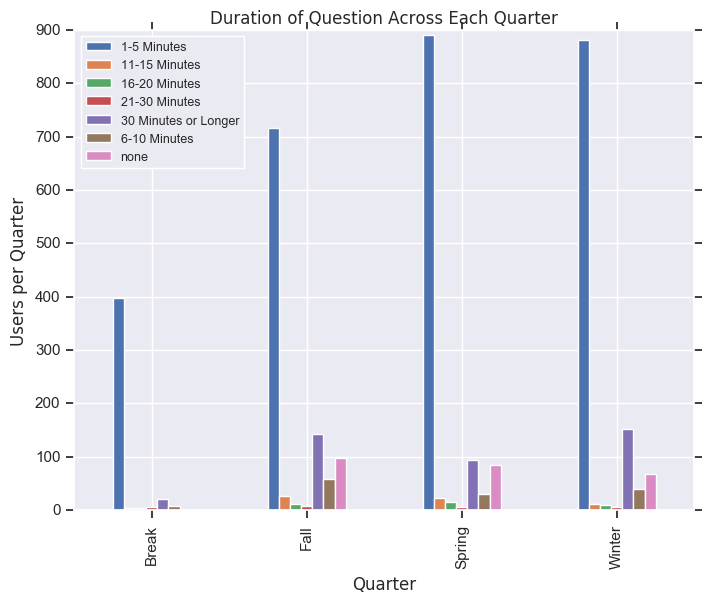

In [90]:
duration_report()